In [66]:
%load_ext autoreload
%autoreload 2

import itertools
from etr.auto_import import *
from etr.data.data_loader import load_data, list_hdb
from datetime import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
HTML(full_width_display)

# Data

In [41]:
syms = ["XRP", "LTC"]
years = [2023, 2024, 2025]
parent_dir = Path(f"../../data/gmo/")

gmo = []
for sym in tqdm(syms):
    for year in years:
        gmo += [pd.read_parquet(file) for file in parent_dir.glob(f"{sym}/{year}*.parquet")]
gmo = pd.concat(gmo)

  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
%%time
trades = pd.concat([
    load_data(["2025-05-01", "2025-05-22"], table="MarketTrade", venue="*", symbol="XRPJPY"),
])
trades["term_amount"] = trade.amount * trade.price / 1e6
trades["latency"] = (trade["timestamp"] - trade.market_created_timestamp).dt.total_seconds() * 1e3

2025-05-24 08:37:35.40 |INFO    |etr.data.data_loader: data_loader.load_data 85|Found 87 HDB files, process loading...
100%|██████████| 87/87 [00:00<00:00, 119.11it/s]


CPU times: user 1.38 s, sys: 267 ms, total: 1.65 s
Wall time: 1.19 s


### Multi-market

In [10]:
%%time
close_1m = trades.set_index("timestamp").groupby("venue").price.resample("1min", label="right").last()
close_1m = close_1m.unstack(level=0).ffill()

CPU times: user 734 ms, sys: 167 ms, total: 901 ms
Wall time: 900 ms


In [12]:
intra_price = close_1m.div(close_1m.resample("1D").first().asof(close_1m.index)).sub(1).mul(1e4)
intra_med = intra_price.groupby(intra_price.index.time).median()
intra_avg = intra_price.groupby(intra_price.index.time).mean()

<Axes: xlabel='timestamp'>

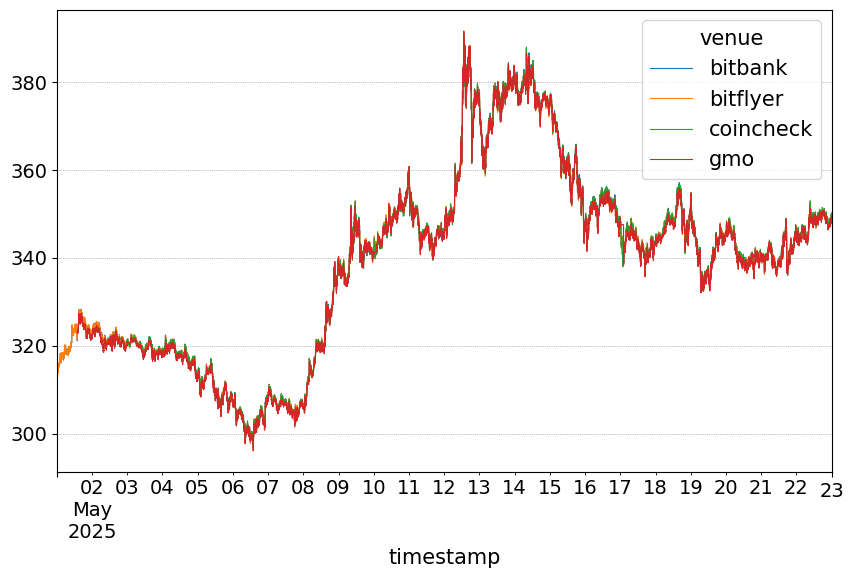

In [30]:
close_1m.plot()

<Axes: xlabel='timestamp'>

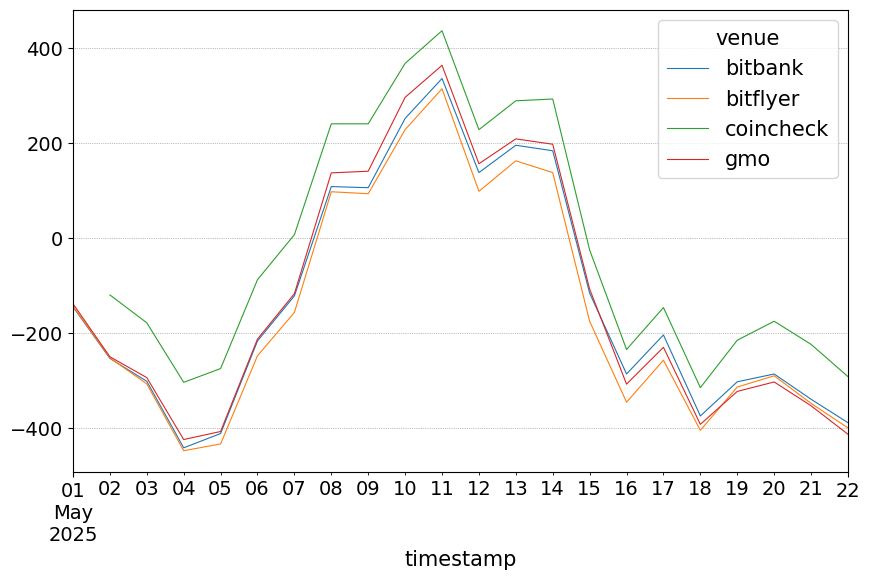

In [36]:
close_1m.between_time(time(16, 30), time(23, 0)).resample("1D").agg(["first", "last"]).stack(level=0).pct_change(axis=1).iloc[:, -1].mul(1e4).unstack(level=-1).cumsum().plot()

<Axes: xlabel='time'>

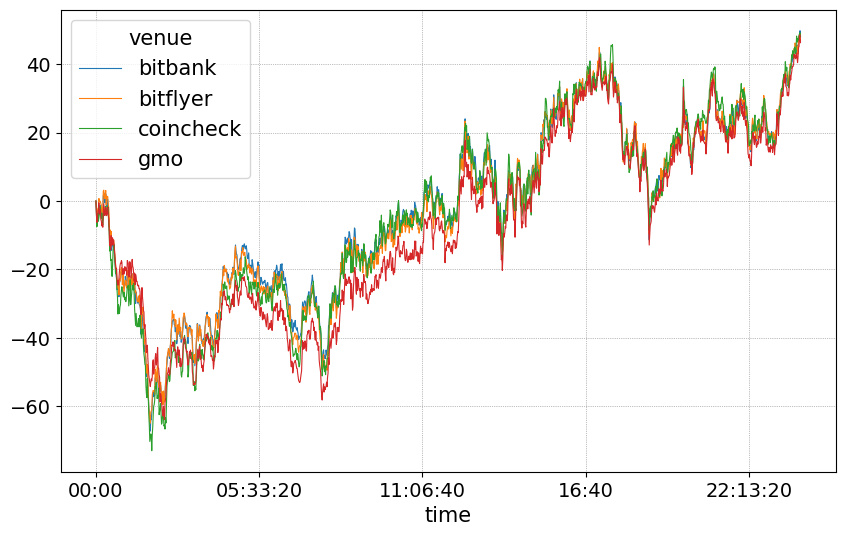

In [19]:
intra_avg.plot()

<Axes: xlabel='time'>

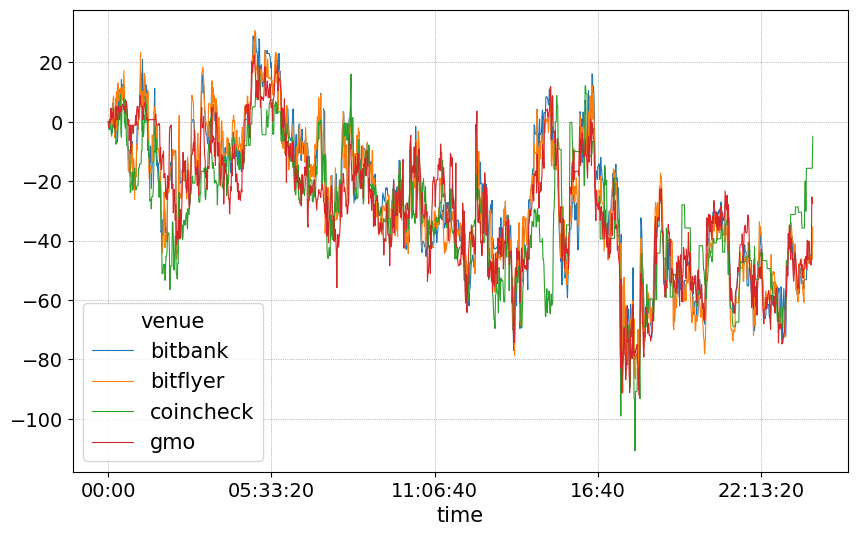

In [20]:
intra_med.plot()

---
### GMO

In [43]:
%%time
close_1m = gmo.set_index("timestamp").groupby("symbol").price.resample("1min", label="right").last()
close_1m = close_1m.unstack(level=0).ffill()

CPU times: user 1.37 s, sys: 348 ms, total: 1.72 s
Wall time: 1.72 s


In [45]:
intra_price = close_1m.div(close_1m.resample("1D").first().asof(close_1m.index)).sub(1).mul(1e4)
intra_med = intra_price.groupby(intra_price.index.time).median()
intra_avg = intra_price.groupby(intra_price.index.time).mean()

<Axes: xlabel='time'>

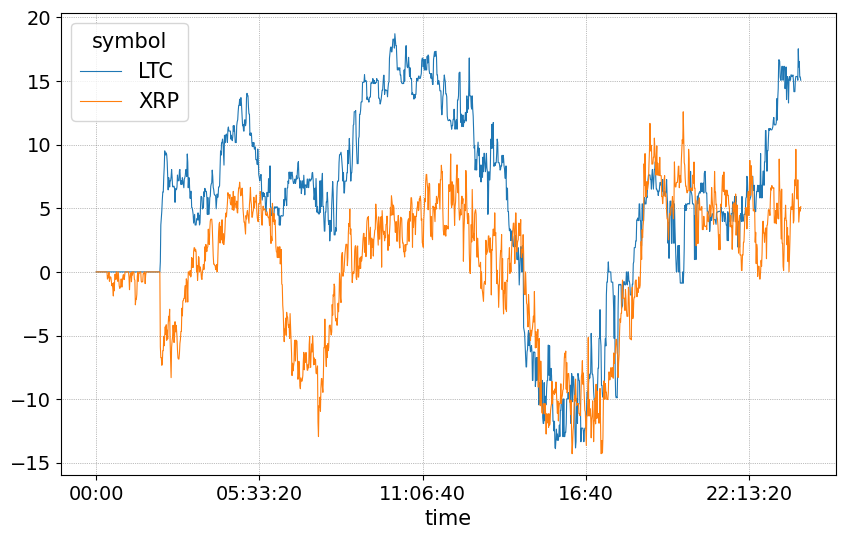

In [72]:
intra_med.plot()

In [74]:
intra_med.iloc[::20].style.format(precision=2).bar()

symbol,LTC,XRP
00:00:00,0.00,0.00
00:20:00,0.00,0.00
00:40:00,0.00,-0.58
01:00:00,0.00,0.00
01:20:00,0.00,-2.58
01:40:00,0.00,-0.92
02:00:00,0.00,0.00
02:20:00,9.51,-4.91
02:40:00,6.56,-5.13
03:00:00,7.30,-2.08


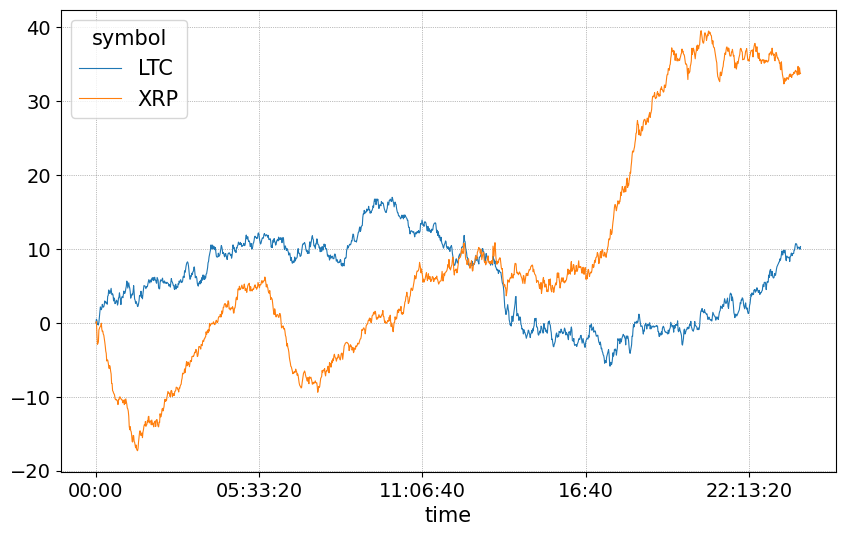

In [60]:
intra_avg.plot();

In [70]:
intra_avg.iloc[::30].style.format(precision=2).bar()

symbol,LTC,XRP
00:00:00,0.00,0.00
00:30:00,4.38,-6.52
01:00:00,4.19,-10.91
01:30:00,3.60,-14.60
02:00:00,6.19,-13.41
02:30:00,5.07,-9.49
03:00:00,6.15,-6.76
03:30:00,5.42,-3.22
04:00:00,10.39,0.16
04:30:00,9.38,3.00


[datetime.time(1, 30), datetime.time(5, 30)]

,count,mean,std,min,25%,50%,75%,max
ret,851.0,19.659239,146.480397,-742.132639,-43.619468,11.340657,76.424067,913.606478


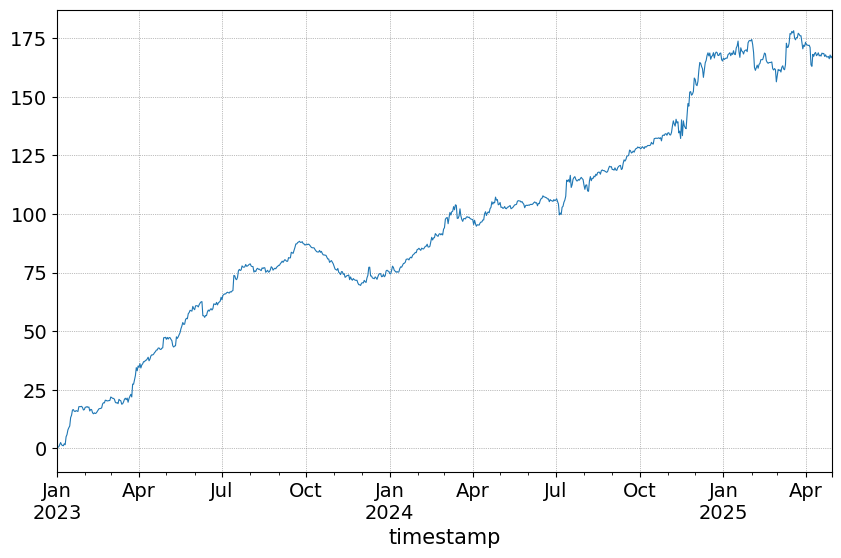

[datetime.time(7, 0), datetime.time(12, 30)]

,count,mean,std,min,25%,50%,75%,max
ret,851.0,18.45149,170.156772,-1033.259424,-54.434773,8.635687,72.633688,1021.375697


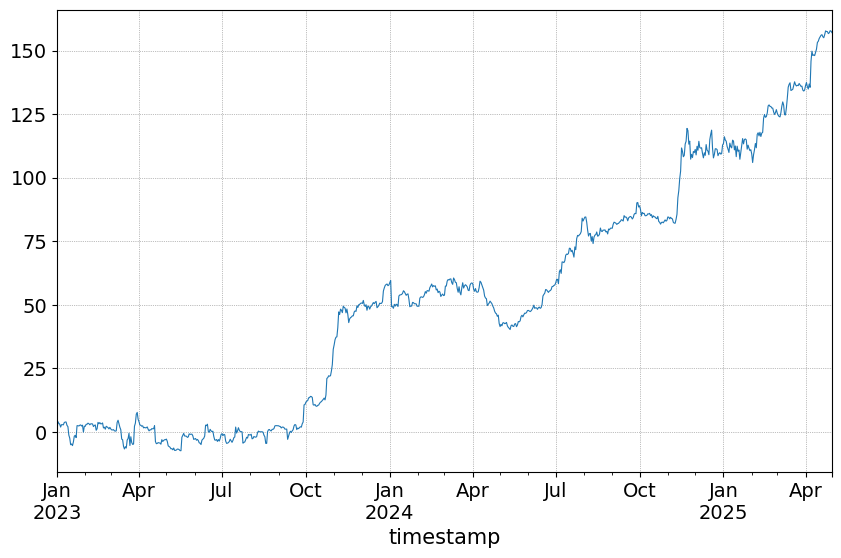

[datetime.time(16, 20), datetime.time(20, 30)]

,count,mean,std,min,25%,50%,75%,max
ret,851.0,28.456805,233.913405,-1742.289371,-39.492094,26.370728,94.299875,3428.595374


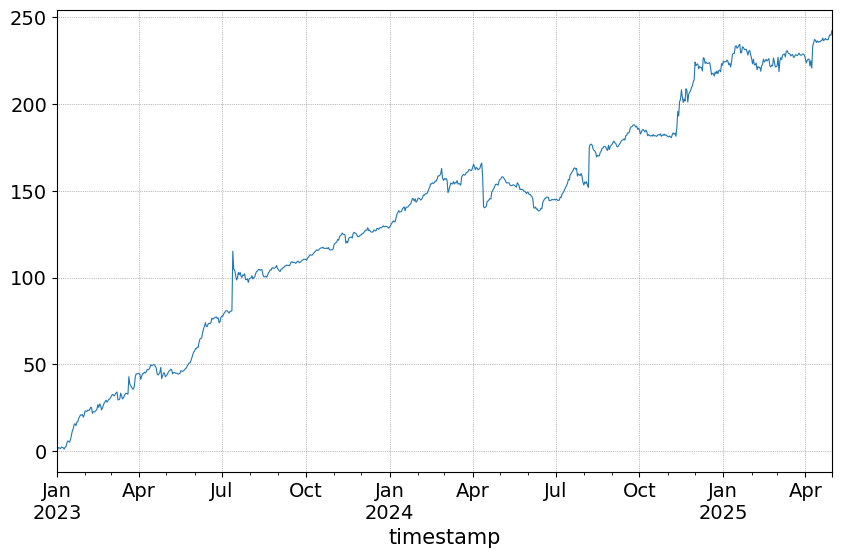

In [98]:
interval1 = [time(1, 30), time(5, 30)]
interval2 = [time(7, 0), time(12, 30)]
# interval3 = [time(12, 0), time(16, 20)]
interval4 = [time(16, 20), time(20, 30)]

for interval in [interval1, interval2, interval4]:
    
    ret = close_1m.between_time(*interval).XRP.resample("1D").agg(["first", "last"]).pct_change(axis=1).mul(1e4).iloc[:, -1].rename("ret")
    display(interval, ret.describe().to_frame().T)
    ret.cumsum().div(1e2).plot()
    plt.show()
    